# Active learning Initialization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.stats import entropy
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Sequential
tf.__version__

'2.3.1'

## Hyper-parameters

In [2]:
EPOCHS = 15
NUM_OF_SAMPLING = 100
SAMPLE_LOOPS = 25

## Dataset

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.reshape(60000, 28, 28, 1).astype('float32') / 255.
X_test = X_test.reshape(10000, 28, 28, 1).astype('float32') / 255.
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

## Model

In [4]:
def build_model_light(input_shape = (28, 28, 1)):
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (4, 4), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    return model


In [5]:
def build_model(input_shape = (28, 28, 1)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (4, 4), activation='relu'))
    model.add(Conv2D(32, (4, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    return model

In [6]:
model = build_model()
# classifier = tf.keras.wrappers.scikit_learn.KerasClassifier(model)

In [7]:
b = model.get_weights()

model.set_weights(b)

a = model.get_weights()

### initial labelled data

In [8]:
def create_init_pool(number_of_samples = 10):
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_train = X_train.reshape(60000, 28, 28, 1).astype('float32') / 255.
    X_test = X_test.reshape(10000, 28, 28, 1).astype('float32') / 255.
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)
    number_of_samples = 10
    initial_idx = np.array([],dtype=np.int)
    for i in range(10):
        idx = np.random.choice(np.where(y_train[:,i]==1)[0], size=number_of_samples, replace=False)
        initial_idx = np.concatenate((initial_idx, idx))

    X_initial = X_train[initial_idx]
    y_initial = y_train[initial_idx]

    X_pool = np.delete(X_train, initial_idx, axis=0)
    y_pool = np.delete(y_train, initial_idx, axis=0)
    return X_train, y_train, X_test, y_test, X_pool, y_pool, X_initial, y_initial
X_train, y_train, X_test, y_test, X_pool, y_pool, X_initial, y_initial = create_init_pool(1000)

### show data

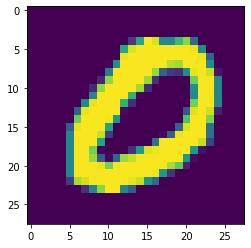

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


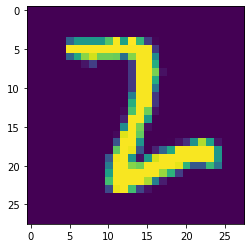

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


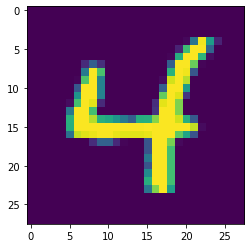

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


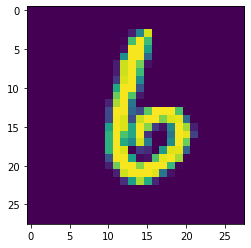

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


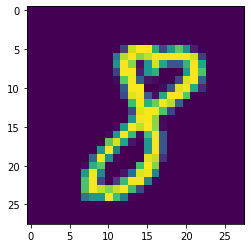

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [9]:
for i in range(0,100,20):
    plt.imshow(X_initial[i])
    plt.show()
    print(y_initial[i])

### Query Strategies

In [10]:
def remove_from_pools(X_pool, y_pool, initial_idx):
    X_pool = np.delete(X_pool, initial_idx, axis=0)
    y_pool = np.delete(y_pool, initial_idx, axis=0)
    return X_pool, y_pool

In [11]:
def get_new_samples(X_pool, y_pool, n=100, stratgy=0, model=None):
    if stratgy == 0: # uniform
        samples = uniform(X_pool, n)
        new_x = samples[1]
        new_y = y_pool[samples[0]]
        X_pool, y_pool = remove_from_pools(X_pool, y_pool, samples[0])
        return X_pool, y_pool, new_x, new_y        
    
    if stratgy == 1: # max_entropy sampling
        samples = max_entropy(model, X_pool, n)
        new_x = samples[1]
        new_y = y_pool[samples[0]]
        X_pool, y_pool = remove_from_pools(X_pool, y_pool, samples[0])
        return X_pool, y_pool, new_x, new_y    

In [12]:
# baseline
def uniform(X, n=1):
    query_idx = np.random.choice(range(len(X)), size=n, replace=False)
    return query_idx, X[query_idx]


def max_entropy(model, X, n=1):
    y = model.predict(X)
    ent = entropy(y.T, base=10)
    query_idx = (-ent).argsort()[:n]
    return query_idx, X[query_idx]
    

### Active Learning

### uniform sampling

In [13]:
metric_uni = []
for i in range(SAMPLE_LOOPS):
    model = None
    model = build_model_light()
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    history = model.fit(x=X_initial, y=y_initial,epochs=EPOCHS, verbose=0)
    metric_uni.append(model.evaluate(X_train, y_train))
    new_samples = get_new_samples(X_pool, y_pool, n=NUM_OF_SAMPLING)
    X_pool, y_pool = new_samples[0], new_samples[1]
    X_initial = np.vstack((X_initial,new_samples[2]))
    y_initial = np.vstack((y_initial,new_samples[3]))

1875/1875 [==============================] - 9s 5ms/step - loss: 0.2703 - accuracy: 0.9431


### max entropy sampling

In [14]:
X_train, y_train, X_test, y_test, X_pool, y_pool, X_initial, y_initial = create_init_pool(1000)

In [15]:
metric_max_ent = []
for i in range(SAMPLE_LOOPS):
    model = None
    model = build_model_light()
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    history = model.fit(x=X_initial, y=y_initial,epochs=EPOCHS, verbose=0)
    metric_max_ent.append(model.evaluate(X_train, y_train))
    new_samples = get_new_samples(X_pool, y_pool, n=NUM_OF_SAMPLING, stratgy=1, model=model)
    X_pool, y_pool = new_samples[0], new_samples[1]
    X_initial = np.vstack((X_initial,new_samples[2]))
    y_initial = np.vstack((y_initial,new_samples[3]))

1875/1875 [==============================] - 6s 3ms/step - loss: 0.0577 - accuracy: 0.9866


### init max entropy sampling

In [16]:
X_train, y_train, X_test, y_test, X_pool, y_pool, X_initial, y_initial = create_init_pool(1000)

In [17]:
metric_init_max_ent = []
for i in range(SAMPLE_LOOPS):
    model = None
    model = build_model_light()
    if i == 0:
        wnb = model.get_weights()
    else:
        model.set_weights(wnb)
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    history = model.fit(x=X_initial, y=y_initial,epochs=EPOCHS, verbose=0)
    metric_init_max_ent.append(model.evaluate(X_train, y_train))
    new_samples = get_new_samples(X_pool, y_pool, n=NUM_OF_SAMPLING, stratgy=1, model=model)
    X_pool, y_pool = new_samples[0], new_samples[1]
    X_initial = np.vstack((X_initial,new_samples[2]))
    y_initial = np.vstack((y_initial,new_samples[3]))

1875/1875 [==============================] - 6s 3ms/step - loss: 0.0591 - accuracy: 0.9855


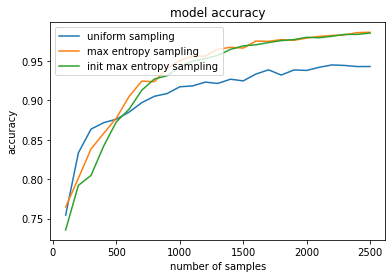

In [18]:
x = range(NUM_OF_SAMPLING,NUM_OF_SAMPLING + NUM_OF_SAMPLING*SAMPLE_LOOPS,NUM_OF_SAMPLING)
metric_uni_np = np.array(metric_uni)
acc_uni = metric_uni_np[:,1]
plt.plot(x, acc_uni)

metric_max_ent_np = np.array(metric_max_ent)
acc_max_ent = metric_max_ent_np[:,1]
plt.plot(x, acc_max_ent)

metric_init_max_ent_np = np.array(metric_init_max_ent)
acc_init_max_ent = metric_init_max_ent_np[:,1]
plt.plot(x, acc_init_max_ent)

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('number of samples')
plt.legend(['uniform sampling', 'max entropy sampling', 'init max entropy sampling'], loc='upper left')